# Importing the Libraries 

In [135]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import mplsoccer
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from tqdm import tqdm
plt.style.use('seaborn-whitegrid')

# Loading the Data

In [2]:
df = pd.read_csv(r"D:\Analytics\Football\Data\Understat\Shots\FullShotsData.csv")

In [3]:
pd.set_option('max_columns',50)

In [4]:
df.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,year,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,378451.0,20,BlockedShot,0.876,0.602,0.019479,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,Matthew Cash,Aerial
1,378458.0,54,MissedShots,0.878,0.430,0.031428,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,Trézéguet,Cross
2,378464.0,77,MissedShots,0.858,0.679,0.060696,Ollie Watkins,h,8865,OpenPlay,2020,RightFoot,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,John McGinn,Pass
3,379954.0,34,MissedShots,0.831,0.655,0.127710,Ollie Watkins,a,8865,OpenPlay,2020,RightFoot,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Jack Grealish,TakeOn
4,379956.0,46,MissedShots,0.943,0.500,0.445354,Ollie Watkins,a,8865,FromCorner,2020,Head,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Conor Hourihane,Cross


# Data Pre-Processing 

Multiplying X & Y values with 100 to get a better plot 

In [5]:
df[['X','Y']] = df[['X','Y']]*100

Removing the shots which are `Blocked` by opposition defenders (since we do not have the location of the defenders) and shots which are resulted into `Own Goals`

In [6]:
df = df[~((df['result']=='BlockedShot')|(df['result']=='OwnGoal'))]

Creating the target variable called `isGoal`

In [7]:
df['isGoal'] = np.where(df['result']=='Goal',1,0)

Creating a function called `calcAngle` to calculate the shot angle to the goal mouth

In [8]:
def calcAngle(x,y):
    b = np.array([x,y])
    a = np.array([100,45])
    c = np.array([100,55])
    ba = a-b
    bc = c-b
    
    cosAngle = np.dot(ba,bc)/(np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosAngle)
    return np.degrees(angle)

In [9]:
df['Angle'] = df.apply(lambda x:calcAngle(x['X'],x['Y']),axis=1)

Calculating distance of the shots from the center of the goal

In [10]:
df['DistanceFromGoal'] = np.sqrt(np.square(100-df['X'])+np.square(50-df['Y']))

Changing all the names of `lastAction` values which appear less than 500 times into `OtherActions`

In [11]:
lastActionsIndexes = df['lastAction'].value_counts()<500
df.loc[df['lastAction'].isin(lastActionsIndexes.index[lastActionsIndexes]),'lastAction'] = 'OtherActions'

# EDA

In [12]:
dfViz = df.copy()

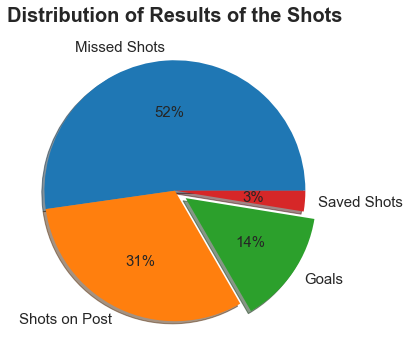

In [13]:
results = dfViz['result'].value_counts().to_dict()
dfResults = pd.DataFrame(results.items(),columns=['Result','Count'])

fig,ax = plt.subplots(figsize=(8,6))
plt.pie(dfResults['Count'],explode=(0,0,0.1,0),shadow=True,textprops={'fontsize':15},
        labels=['Missed Shots','Shots on Post','Goals','Saved Shots'],autopct='%.0f%%')
plt.title('Distribution of Results of the Shots',fontsize=20,fontweight='bold')
plt.show()

Only 14% of the the shots taken by the players are successfully converted into goals.

In [14]:
situation = dfViz['situation'].value_counts().to_dict()
situationG = dfViz[dfViz['isGoal']==1]['situation'].value_counts().to_dict()

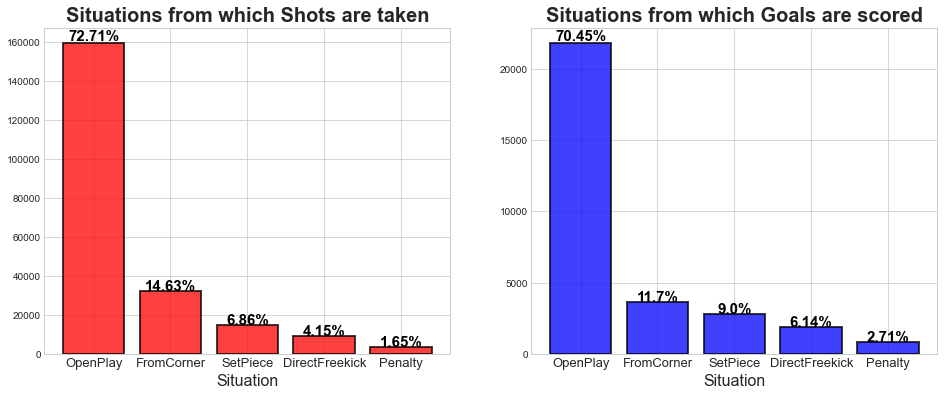

In [15]:
fig,axs = plt.subplots(1,2,figsize=(16,6))
axs[0].bar(situation.keys(),situation.values(),edgecolor='k',linewidth=2,color='red',alpha=.75)
axs[0].set_xlabel('Situation',fontsize=16)
axs[0].set_xticklabels(situation.keys(),fontsize=13)
axs[0].set_title('Situations from which Shots are taken',fontsize=20,fontweight='bold')
for key,value in situation.items():
    axs[0].text(key,value+0.01*value,
                str(round(value*100/sum(situation.values()),2))+'%',
                c='k',fontweight='bold',ha='center',size=15)

axs[1].bar(situationG.keys(),situationG.values(),edgecolor='k',linewidth=2,color='blue',alpha=.75)
axs[1].set_xlabel('Situation',fontsize=16)
axs[1].set_xticklabels(situation.keys(),fontsize=13)
axs[1].set_title('Situations from which Goals are scored',fontsize=20,fontweight='bold')
for key,value in situationG.items():
    axs[1].text(key,value+0.01*value,
                str(round(value*100/sum(situationG.values()),2))+'%',
                c='k',fontweight='bold',ha='center',size=15)

plt.show()

According to the distribution above, around 70% of the shots and goals come from open play situations, while the remaining come from dead ball situations like corners, set pieces, freekicks and penalties

In [16]:
dfSitShot = pd.DataFrame(situation.items(),columns=['Situation','ShotCount'])
dfSitGoal = pd.DataFrame(situationG.items(),columns=['Situation','GoalCount'])
dfSit = dfSitShot.merge(dfSitGoal,on='Situation')
dfSit['Conversion'] = (dfSit['GoalCount']/dfSit['ShotCount'])*100

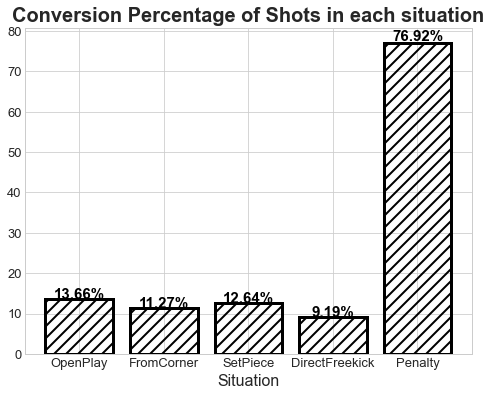

In [17]:
mpl.rcParams['hatch.linewidth'] = 2
plt.figure(figsize=(8,6))
plt.bar(dfSit['Situation'],dfSit['Conversion'],linewidth=3,edgecolor='k',color='None',hatch='//')
plt.xlabel('Situation',fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Conversion Percentage of Shots in each situation',fontsize=20,fontweight='bold')
for idx,row in dfSit.iterrows():
    plt.text(dfSit['Situation'][idx],dfSit['Conversion'][idx]+0.01*dfSit['Conversion'][idx],
                str(round(dfSit['Conversion'][idx],2))+'%',
                c='k',fontweight='bold',ha='center',size=15)

plt.show()

The rate at which shots are converted into goals is around 9-14% in all situations except penalties. <br>
For penalties, the conversion rate is nearly 77%. This is because,
* There will not be any opposition defenders blocking the shot during the penalties apart from the GoalKeeper.
* Also the shot location and shot angle for the penalties is fixed and optimal for scoring goals.

In [18]:
shotPart = dfViz['shotType'].value_counts().to_dict()
shotPartG = dfViz[dfViz['isGoal']==1]['shotType'].value_counts().to_dict()

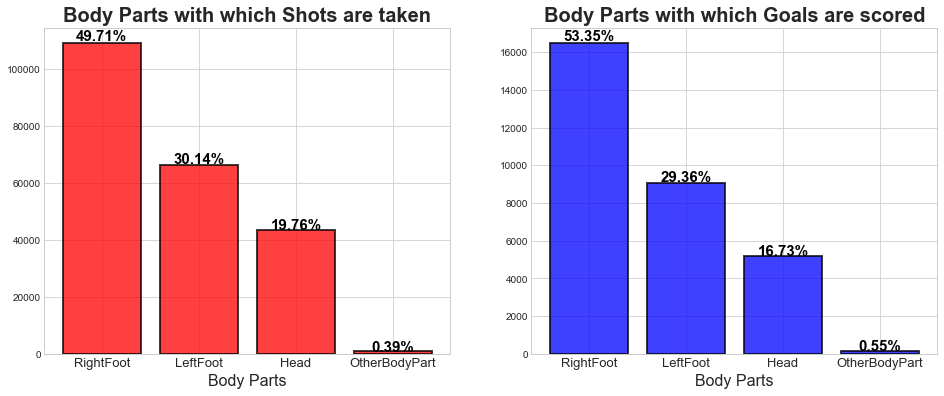

In [19]:
fig,axs = plt.subplots(1,2,figsize=(16,6))
axs[0].bar(shotPart.keys(),shotPart.values(),edgecolor='k',linewidth=2,color='red',alpha=.75)
axs[0].set_xlabel('Body Parts',fontsize=16)
axs[0].set_xticklabels(shotPart.keys(),fontsize=13)
axs[0].set_title('Body Parts with which Shots are taken',fontsize=20,fontweight='bold')
for key,value in shotPart.items():
    axs[0].text(key,value+0.01*value,
                str(round(value*100/sum(shotPart.values()),2))+'%',
                c='k',fontweight='bold',ha='center',size=15)


axs[1].bar(shotPartG.keys(),shotPartG.values(),edgecolor='k',linewidth=2,color='blue',alpha=.75)
axs[1].set_xlabel('Body Parts',fontsize=16)
axs[1].set_xticklabels(shotPart.keys(),fontsize=13)
axs[1].set_title('Body Parts with which Goals are scored',fontsize=20,fontweight='bold')
for key,value in shotPartG.items():
    axs[1].text(key,value+0.01*value,
                str(round(value*100/sum(shotPartG.values()),2))+'%',
                c='k',fontweight='bold',ha='center',size=15)


plt.show()

* Players use their feet for nearly 80-85% of their shots and goals.
* In the remaining 15-20%, they use their head and very rarely other body parts like Torso and Shoulder. 

In [20]:
lastAction = dfViz['lastAction'].value_counts().to_dict()
lastActionG = dfViz[dfViz['isGoal']==1]['lastAction'].value_counts().to_dict()

In [21]:
dfLastAction = pd.DataFrame(lastAction.items(),columns=['LastAction','Count'])
dfLastActionG = pd.DataFrame(lastActionG.items(),columns=['LastAction','Count'])

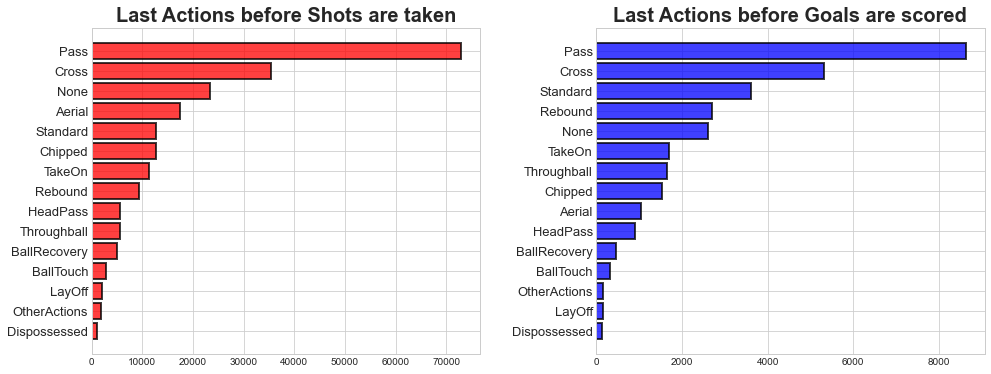

In [22]:
fig,axs = plt.subplots(1,2,figsize=(16,6))
plt.subplots_adjust(wspace=.3)

axs[0].barh(dfLastAction['LastAction'],dfLastAction['Count'],edgecolor='k',linewidth=2,color='red',alpha=.75)
axs[0].set_yticklabels(lastAction.keys(),fontsize=13)
axs[0].set_title('Last Actions before Shots are taken',fontsize=20,fontweight='bold')
axs[0].invert_yaxis()

axs[1].barh(dfLastActionG['LastAction'],dfLastActionG['Count'],edgecolor='k',linewidth=2,color='blue',alpha=.75)
axs[1].set_yticklabels(lastActionG.keys(),fontsize=13)
axs[1].set_title('Last Actions before Goals are scored',fontsize=20,fontweight='bold')
axs[1].invert_yaxis()

plt.show()

The last action before most of the shots and goals are usually either passes or crosses.

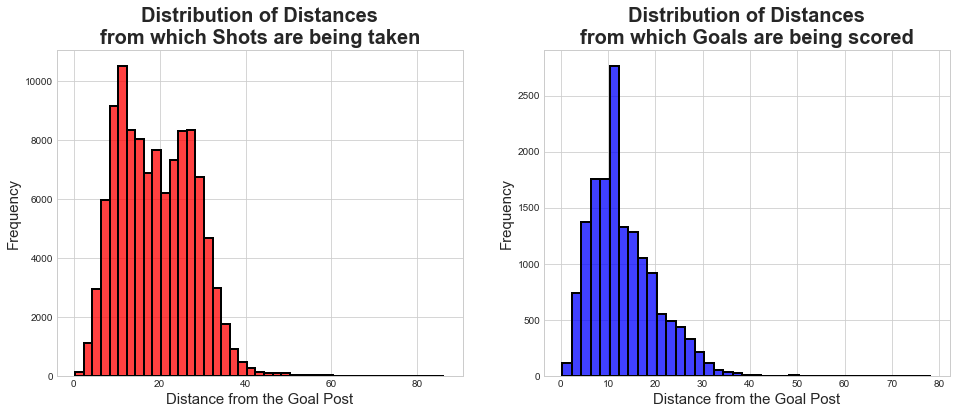

In [23]:
fig,axs = plt.subplots(1,2,figsize=(16,6))
sns.histplot(x='DistanceFromGoal',binwidth=2,data=dfViz,stat='frequency',
             color='red',alpha=.75,lw=2,ax=axs[0])
axs[0].set_xlabel('Distance from the Goal Post',fontsize=15)
axs[0].set_ylabel('Frequency',fontsize=15)
axs[0].set_title('Distribution of Distances\nfrom which Shots are being taken',fontsize=20,fontweight='bold')

dfGViz = dfViz[dfViz['isGoal']==1]
sns.histplot(x='DistanceFromGoal',binwidth=2,data=dfGViz,stat='frequency',
             color='blue',alpha=.75,lw=2,ax=axs[1])
axs[1].set_xlabel('Distance from the Goal Post',fontsize=15)
axs[1].set_ylabel('Frequency',fontsize=15)
axs[1].set_title('Distribution of Distances\nfrom which Goals are being scored',fontsize=20,fontweight='bold')

plt.show()

* There is a high frequency of shots from 5-35 units distance from the goal.
* There is high frequency of goals being scored from 5-20 units distance from the goal.
* There are a very few shots which are taken from less than 5 units and more than 40 units distance away from the goal.

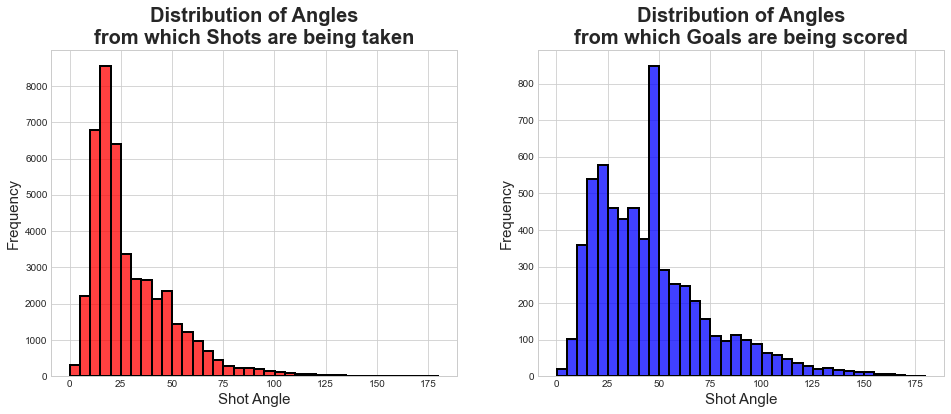

In [24]:
fig,axs = plt.subplots(1,2,figsize=(16,6))
sns.histplot(x='Angle',binwidth=5,data=dfViz,stat='frequency',
             color='red',alpha=.75,lw=2,ax=axs[0])
axs[0].set_xlabel('Shot Angle',fontsize=15)
axs[0].set_ylabel('Frequency',fontsize=15)
axs[0].set_title('Distribution of Angles\nfrom which Shots are being taken',fontsize=20,fontweight='bold')

sns.histplot(x='Angle',binwidth=5,data=dfGViz,stat='frequency',
             color='blue',alpha=.75,lw=2,ax=axs[1])
axs[1].set_xlabel('Shot Angle',fontsize=15)
axs[1].set_ylabel('Frequency',fontsize=15)
axs[1].set_title('Distribution of Angles\nfrom which Goals are being scored',fontsize=20,fontweight='bold')

plt.show()

* There is a high frequency of shots from 15-30 degrees of Shot Angle with resepct to the Goal Post.
* There is high frequency of goals being scored from 20-50 degrees of Shot Angle with resepct to the Goal Post.
* Players rarely take shots when their shot angle is less than 5 degrees or more than 75 degrees.

In [152]:
dfViz['DistanceBins'] = pd.qcut(dfViz['DistanceFromGoal'],q=50)
dfVizDistanceBins = dfViz.groupby('DistanceBins')['isGoal'].mean().reset_index()
dfVizDistanceBins['meanDistance'] = dfViz.groupby('DistanceBins',as_index=False)['DistanceFromGoal'].mean()['DistanceFromGoal']

In [153]:
dfNP = df[df['situation']!='Penalty']
dfNP['DistanceBins'] = pd.qcut(dfNP['DistanceFromGoal'],q=50)
dfNPDistanceBins = dfNP.groupby('DistanceBins')['isGoal'].mean().reset_index()
dfNPDistanceBins['meanDistance'] = dfNP.groupby('DistanceBins',as_index=False)['DistanceFromGoal'].mean()['DistanceFromGoal']

<ipython-input-153-043930534da8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNP['DistanceBins'] = pd.qcut(dfNP['DistanceFromGoal'],q=50)


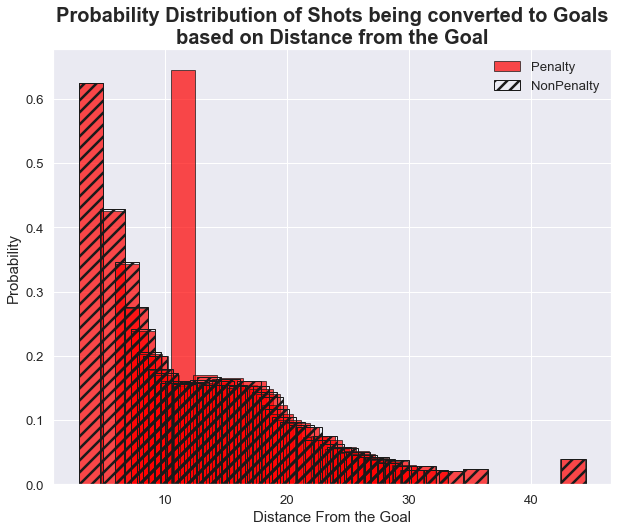

In [192]:
mpl.rcParams['hatch.linewidth']=2.5
fig,axs = plt.subplots(figsize=(10,8))
plt.bar(dfVizDistanceBins['meanDistance'],dfVizDistanceBins['isGoal'],width=2,color='red',edgecolor='k',alpha=.7,label='Penalty')
plt.bar(dfNPDistanceBins['meanDistance'],dfNPDistanceBins['isGoal'],width=2,edgecolor='k',color='None',hatch='//',label='NonPenalty')
plt.xlabel('Distance From the Goal',fontsize=15)
plt.ylabel('Probability',fontsize=15)

plt.title('Probability Distribution of Shots being converted to Goals\nbased on Distance from the Goal',fontsize=20,fontweight='bold')
plt.legend()

plt.show()

In [181]:
dfViz['AngleBins'] = pd.qcut(dfViz['Angle'],q=50)
dfVizAngleBins = dfViz.groupby('AngleBins')['isGoal'].mean().reset_index()
dfVizAngleBins['meanAngle'] = dfViz.groupby('AngleBins',as_index=False)['Angle'].mean()['Angle']

In [182]:
dfNP['AngleBins'] = pd.qcut(dfNP['Angle'],q=50)
dfNPAngleBins = dfNP.groupby('AngleBins')['isGoal'].mean().reset_index()
dfNPAngleBins['meanAngle'] = dfNP.groupby('AngleBins',as_index=False)['Angle'].mean()['Angle']

<ipython-input-182-3e8a394ff14a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNP['AngleBins'] = pd.qcut(dfNP['Angle'],q=50)


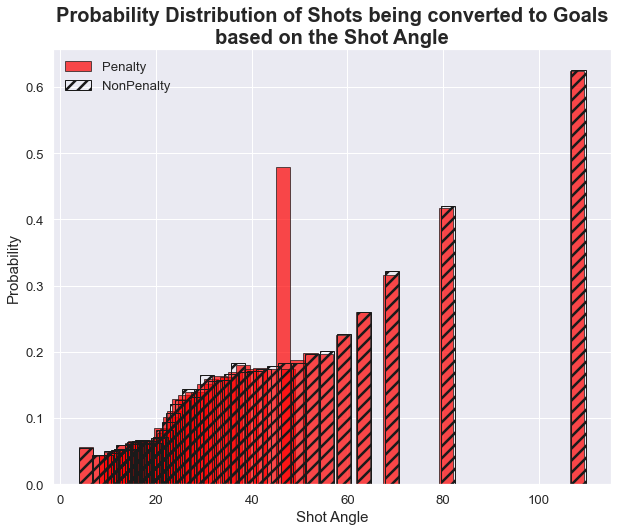

In [193]:
mpl.rcParams['hatch.linewidth']=2.5
fig,axs = plt.subplots(figsize=(10,8))
plt.bar(dfVizAngleBins['meanAngle'],dfVizAngleBins['isGoal'],width=3,color='red',edgecolor='k',alpha=.7,label='Penalty')
plt.bar(dfNPAngleBins['meanAngle'],dfNPAngleBins['isGoal'],width=3,edgecolor='k',color='None',hatch='//',label='NonPenalty')
plt.legend()
plt.xlabel('Shot Angle',fontsize=15)
plt.ylabel('Probability',fontsize=15)
plt.title('Probability Distribution of Shots being converted to Goals\nbased on the Shot Angle',fontsize=20,fontweight='bold')
plt.show()

In [25]:
customcmap = LinearSegmentedColormap.from_list('custom cmap', ['#2b2b2b', '#ff0000'])

In [26]:
vertPitch = VerticalPitch(pitch_type='opta',line_color='#ffffff',line_zorder=2,
                          pitch_color='#2b2b2b',half=True,goal_type='box',
                          pad_top=0.05, pad_right=0.05,
                          pad_left=0.05,pad_bottom=0)

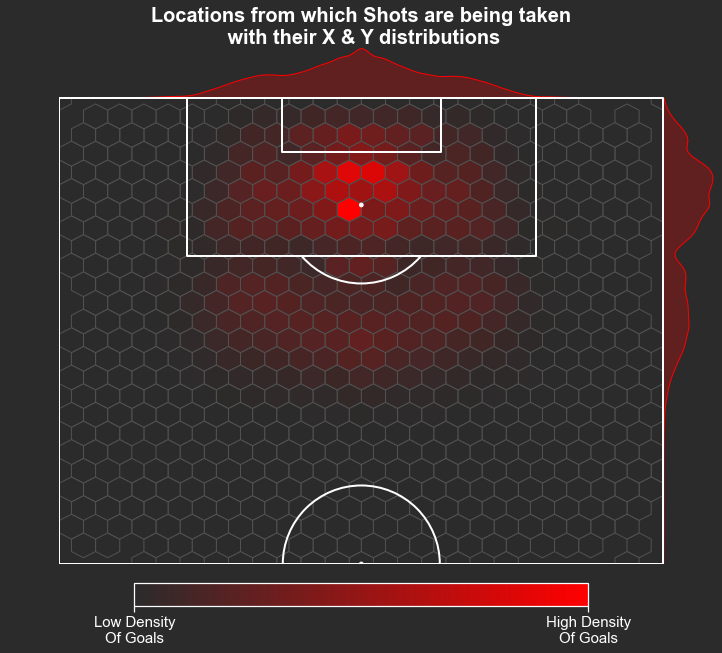

In [212]:
fig, axs = vertPitch.jointgrid(left=None,bottom=0.075, grid_height=0.8,
                           axis=False,  
                           endnote_height=0, title_height=0) 
fig.set_facecolor('#2b2b2b')

hexmap = vertPitch.hexbin(dfViz['X'],dfViz['Y'],
                          ax=axs['pitch'],gridsize=(25,25),
                          edgecolor='#525252',cmap=customcmap)
sns.kdeplot(y=dfViz.X, ax=axs['right'],color='#ff0000',shade=True)
sns.kdeplot(x=dfViz.Y, ax=axs['top'],color='#ff0000',shade=True)

fig.suptitle(y=.935,t='Locations from which Shots are being taken\n with their X & Y distributions',color='w',fontsize=20,fontweight='bold')


ax2 = fig.add_axes([0.1,0.01,0.8,0.1])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_facecolor('None')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)


cbar = plt.colorbar(hexmap,ax=ax2,orientation='horizontal',fraction=.35)
cbar.set_ticks([cbar.vmin,cbar.vmax])
cbar.ax.xaxis.set_tick_params(color='white',labelsize=15)
cbar.ax.set_xticklabels(['Low Density\nOf Goals','High Density\nOf Goals'],color='w')


plt.show()

Even though the shots are taken from all over the opposition half, most of the shots come from in and around the goal box. 

In [28]:
customcmap1 = LinearSegmentedColormap.from_list('custom cmap', ['#2b2b2b', '#ff0000', '#ff0000'])

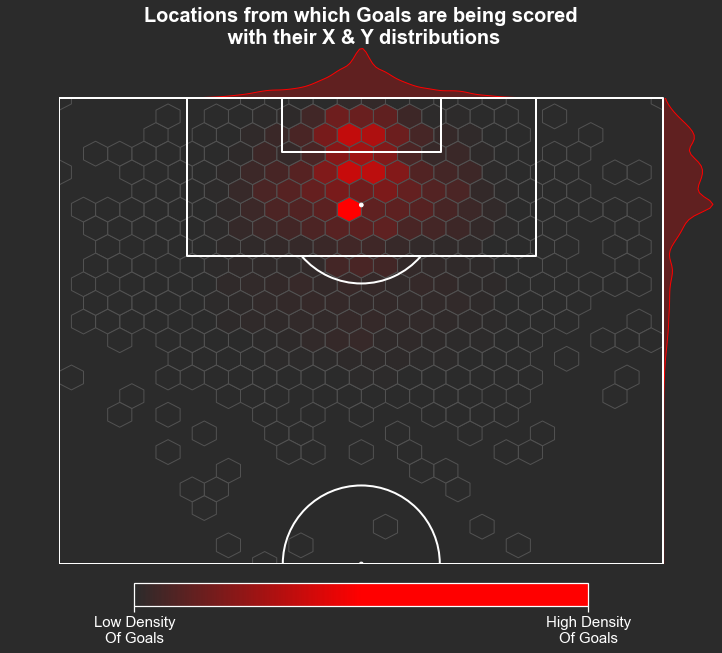

In [211]:
fig, axs = vertPitch.jointgrid(left=None,bottom=0.075, grid_height=0.8,
                           axis=False,  
                           endnote_height=0, title_height=0)
fig.set_facecolor('#2b2b2b')
hexmap = vertPitch.hexbin(dfGViz['X'],dfGViz['Y'],
                          ax=axs['pitch'],gridsize=(25,25),
                          edgecolor='#525252',cmap=customcmap1)
sns.kdeplot(y=dfGViz.X, ax=axs['right'],color='#ff0000',shade=True)
sns.kdeplot(x=dfGViz.Y, ax=axs['top'],color='#ff0000',shade=True)

fig.suptitle(y=.935,t='Locations from which Goals are being scored\n with their X & Y distributions',color='w',fontsize=20,fontweight='bold')


ax2 = fig.add_axes([0.1,0.01,0.8,0.1])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_facecolor('None')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)


cbar = plt.colorbar(hexmap,ax=ax2,orientation='horizontal',fraction=.35)
cbar.set_ticks([cbar.vmin,cbar.vmax])
cbar.ax.xaxis.set_tick_params(color='white',labelsize=15)
cbar.ax.set_xticklabels(['Low Density\nOf Goals','High Density\nOf Goals'],color='w')

plt.show()

Most of the goals come from the central locations inside the goal-box 

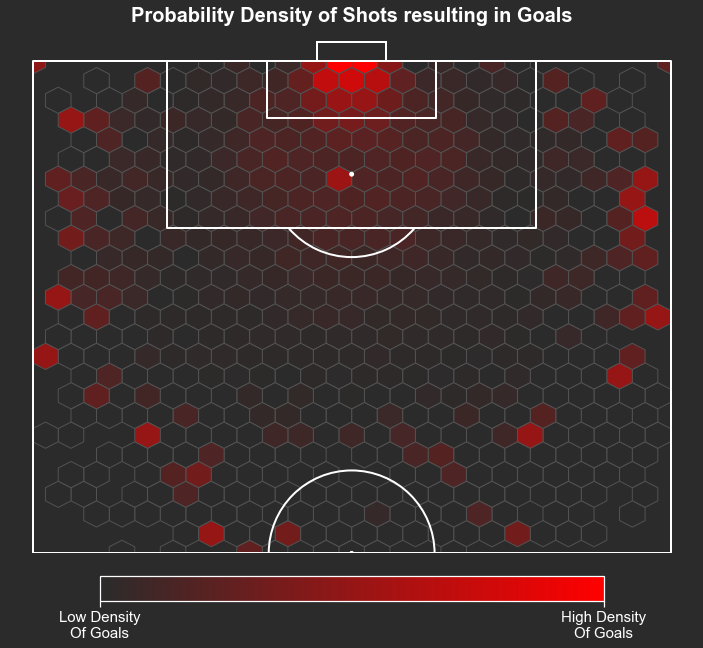

In [223]:
prob = np.array(dfViz['isGoal'])
pitch = VerticalPitch(pitch_type='opta',pitch_color='#2b2b2b',line_color='white',goal_type='box',line_zorder=2,half=True,pad_bottom=0) 
fig, ax = pitch.draw(figsize=(10,10))
fig.set_facecolor('#2b2b2b')

hexmap = pitch.hexbin(dfViz['X'],dfViz['Y'],C=prob,reduce_C_function=np.mean,
                          ax=ax,gridsize=(25,25),
                          edgecolor='#525252',cmap=customcmap)

fig.suptitle(y=.875,t='Probability Density of Shots resulting in Goals',color='w',fontsize=20,fontweight='bold')


ax2 = fig.add_axes([0.1,0.05,0.8,0.1])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_facecolor('None')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)


cbar = plt.colorbar(hexmap,ax=ax2,orientation='horizontal',fraction=.35)
cbar.set_ticks([cbar.vmin,cbar.vmax])
cbar.ax.xaxis.set_tick_params(color='white',labelsize=15)
cbar.ax.set_xticklabels(['Low Density\nOf Goals','High Density\nOf Goals'],color='w')


plt.show()

# Modeling

In [30]:
df.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,year,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,isGoal,Angle,DistanceFromGoal
1,378458.0,54,MissedShots,87.800003,43.000000,0.031428,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,Trézéguet,Cross,0,35.216557,14.065558
2,378464.0,77,MissedShots,85.800003,67.900002,0.060696,Ollie Watkins,h,8865,OpenPlay,2020,RightFoot,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,John McGinn,Pass,0,15.943871,22.848413
3,379954.0,34,MissedShots,83.099998,65.500000,0.127710,Ollie Watkins,a,8865,OpenPlay,2020,RightFoot,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Jack Grealish,TakeOn,0,18.645405,22.931639
4,379956.0,46,MissedShots,94.300003,50.000000,0.445354,Ollie Watkins,a,8865,FromCorner,2020,Head,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Conor Hourihane,Cross,0,82.514054,5.699997
5,381490.0,3,Goal,91.599998,52.400002,0.510213,Ollie Watkins,h,8865,OpenPlay,2020,LeftFoot,14466,Aston Villa,Liverpool,7,2,2020-10-04 18:15:00,Jack Grealish,Pass,1,58.577045,8.736134


Since we do not know the information if the player is using preferred foot or unpreferred foot while taking the shot, we change the `RightFoot` and `LeftFoot` values in the `shotType` column to `Foot`.

In [31]:
df['shotType'] = np.where(df['shotType']=='LeftFoot','Foot',df['shotType'])
df['shotType'] = np.where(df['shotType']=='RightFoot','Foot',df['shotType'])

Selecting the Predictor and Response variables for the model

In [32]:
X = df[['X','Y','situation','shotType','lastAction','Angle','DistanceFromGoal']]
y = df['isGoal']

Encoding the Categorical Variables using One-Hot Encoding

In [33]:
columnsOHE = X.select_dtypes(include='object').columns.to_list()

In [34]:
listOHE = []
for column in columnsOHE:
    listOHE.append(pd.get_dummies(X[column]))

In [35]:
dfOHE = pd.concat(listOHE,axis=1)

In [36]:
X = X.drop(columns=columnsOHE) # Dropping the categorical variables

In [37]:
X = pd.concat([X,dfOHE],axis=1) # Concating the one-hot encoded variables

Using `train_test_split` to make the training and testing sets

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=10,stratify=y)

## Base Model

### Decision Tree algorithm

#### Vanilla Decision Tree

In [39]:
dtree = DecisionTreeClassifier(random_state=23) # Loading the Decision Tree Classifier

In [40]:
dtree.fit(X_train,y_train) # Fitting on the training data

DecisionTreeClassifier(random_state=23)

In [41]:
y_train_pred = dtree.predict(X_train) # Predicting on the training data
y_test_pred = dtree.predict(X_test) # Predicting on the testing data
y_test_prob = dtree.predict_proba(X_test)[:,1] # Predicting the probabilities on test data

#### Performance Metrics

In [42]:
print('Accuracy of the Vanilla Decision Tree Classifier on the Training Data : {:.4f} %'.format(accuracy_score(y_train,y_train_pred)*100))
print('Accuracy of the Vanilla Decision Tree Classifier on the Testing Data : {:.4f} %'.format(accuracy_score(y_test,y_test_pred)*100))

Accuracy of the Vanilla Decision Tree Classifier on the Training Data : 97.2781 %
Accuracy of the Vanilla Decision Tree Classifier on the Testing Data : 81.6218 %


In [43]:
print('ROC-AUC score of the Vanilla Decision Tree Classifier : {:.4f}'.format(roc_auc_score(y_test,y_test_prob)))

ROC-AUC score of the Vanilla Decision Tree Classifier : 0.6289


#### Finding the best `max_depth` value of the Decision Tree

In [44]:
# Using cross-validation to find the best max_depth value
accuracyVal = {}
for i in range(1,10):
    dtree = DecisionTreeClassifier(max_depth=i)
    cv = cross_validate(dtree,X_train,y_train,scoring='accuracy',cv=10)
    accuracyVal[i] = cv['test_score'].mean()

In [45]:
# Assigning the best max_depth value as max_depth with best validation accuracy
bestDepth = [key for (key,value) in accuracyVal.items() if value==max(accuracyVal.values())][0]

#### Decision Tree with best `max_depth` value

In [46]:
# Creating a Decision Tree with best max_depth
dtreeBest = DecisionTreeClassifier(max_depth=bestDepth)

In [47]:
# Fitting on the Training Data
dtreeBest.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7)

In [48]:
y_train_pred = dtreeBest.predict(X_train) # Predicting on the training data
y_test_pred = dtreeBest.predict(X_test) # Predicting on the testing data
y_test_prob = dtreeBest.predict_proba(X_test)[:,1] # Predicting the probabilities on test data

#### Performance Metrics

In [49]:
print('Accuracy of the Decision Tree Classifier with best max_depth value on the Training Data : {:.4f} %'.format(accuracy_score(y_train,y_train_pred)*100))
print('Accuracy of the Decision Tree Classifier with best max_depth value on the Testing Data : {:.4f} %'.format(accuracy_score(y_test,y_test_pred)*100))

Accuracy of the Decision Tree Classifier with best max_depth value on the Training Data : 87.5151 %
Accuracy of the Decision Tree Classifier with best max_depth value on the Testing Data : 87.6118 %


In [50]:
print('ROC-AUC score of the Decision Tree Classifier after Hyper-Parameter Tuning : {:.4f}'.format(roc_auc_score(y_test,y_test_prob)))

ROC-AUC score of the Decision Tree Classifier after Hyper-Parameter Tuning : 0.8018


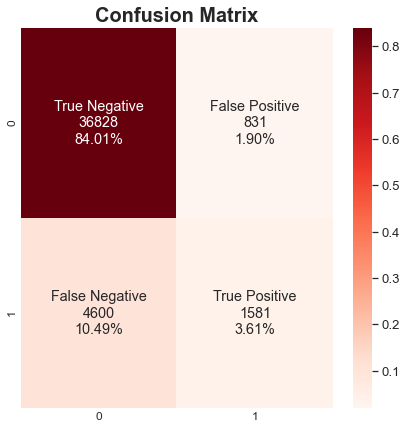

In [51]:
fig,ax = plt.subplots(figsize=(7,7))

conf_matrix = confusion_matrix(y_test, y_test_pred)
names = ['True Negative','False Positive','False Negative','True Positive']
counts = ['{}'.format(value) for value in conf_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix/np.sum(conf_matrix),fmt='',cmap='Reds',ax=ax,annot=labels)
ax.tick_params(axis='both', which='major', labelsize=12) 

plt.title('Confusion Matrix',fontsize=20,fontweight='bold')

plt.show()

In [52]:
precision = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])

In [53]:
print('Precision of the Decision Tree Classifier after Hyper-Parameter Tuning : {:.2f} %'.format(precision*100))
print('False Positive Rate of the Decision Tree Classifier after Hyper-Parameter Tuning : {:.2f} %'.format(fpr*100))

Precision of the Decision Tree Classifier after Hyper-Parameter Tuning : 65.55 %
False Positive Rate of the Decision Tree Classifier after Hyper-Parameter Tuning : 2.21 %


#### Feature Importance

In [54]:
# Using the feature importance attribute of Decision Tree
featImp = dtreeBest.feature_importances_
dfFeatImp = pd.DataFrame({'FeatureName':X_train.columns,'FeatureImportance':featImp})

In [55]:
# Features with feature importance of more than 0.01 
dfFeatImp = dfFeatImp[dfFeatImp['FeatureImportance']>0.01]

In [56]:
# Sorting the values in dataframe by Feature Importance
dfFeatImp.sort_values(by='FeatureImportance',inplace=True)

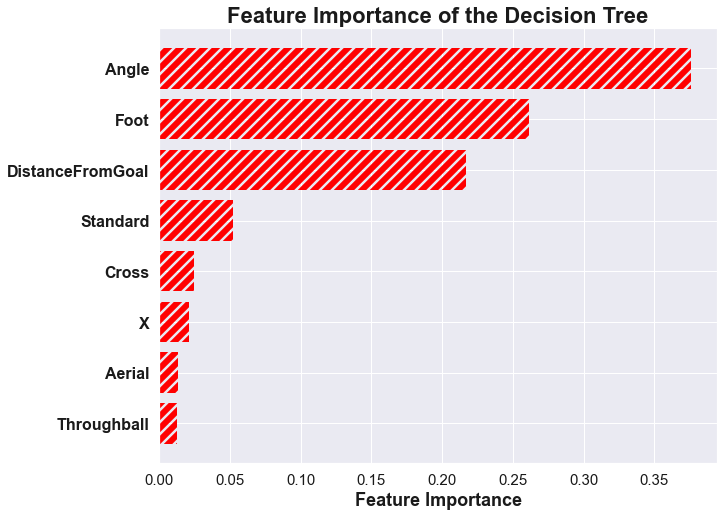

In [57]:
mpl.rcParams['hatch.linewidth']=6
fig,ax = plt.subplots(figsize=(10,8))

plt.barh(dfFeatImp['FeatureName'],dfFeatImp['FeatureImportance'],
         color='None',edgecolor='red',hatch='//',lw=0)
plt.xlabel('Feature Importance',fontsize=18,fontweight='bold',color='k')

plt.yticks(fontsize=16,color='k',fontweight='bold')
plt.xticks(fontsize=15,color='k')

plt.title('Feature Importance of the Decision Tree',fontsize=22,fontweight='bold',color='k')
plt.show()

The Shot Angle, Distance from the Goal and whether the Shot is taken by Foot or not, seem to be the most important features according to the Decision Tree Classifier

## Ensemble Models

### Random Forest Classifier

In [59]:
# Assigning parameters to perform Grid-Search on
params = {'n_estimators' : [50,100,200,400],'criterion': ['gini', 'entropy'],'max_depth':[5,6,7,8,9,10]}

In [60]:
# Creating a Random Forest Model to perform Grid Search with
rf = RandomForestClassifier(random_state=23)

In [61]:
# Creating the GridSearch object 
clf = GridSearchCV(rf,params,cv=5,return_train_score=True,scoring='accuracy',n_jobs=-1)

In [62]:
# Fitting it on the training data
clf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=23), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 100, 200, 400]},
             return_train_score=True, scoring='accuracy')

In [63]:
# Assigning the best parameter values
best_criteria = clf.best_params_['criterion']
best_depth = clf.best_params_['max_depth']
best_est = clf.best_params_['n_estimators']

In [78]:
# Creating a Random Forest Model with the best hyper-parameters found through GridSearch
rfBest = RandomForestClassifier(criterion=best_criteria,max_depth=best_depth,n_estimators=best_est)

In [79]:
# Fitting on the training data
rfBest.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200)

In [80]:
y_train_pred = rfBest.predict(X_train) # Predicting on the training data
y_test_pred = rfBest.predict(X_test) # Predicting on the testing data
y_test_prob = rfBest.predict_proba(X_test)[:,1] # Predicting the probabilities on test data

In [82]:
print('Accuracy of the Random Forest Classifier after hyper-parameter tuning on the Training Data : {:.4f} %'.format(accuracy_score(y_train,y_train_pred)*100))
print('Accuracy of the Random Forest Classifier after hyper-parameter tuning on the Testing Data : {:.4f} %'.format(accuracy_score(y_test,y_test_pred)*100))

Accuracy of the Random Forest Classifier after hyper-parameter tuning on the Training Data : 87.6668 %
Accuracy of the Random Forest Classifier after hyper-parameter tuning on the Testing Data : 87.7418 %


In [83]:
print('ROC-AUC score of the Random Forest Classifier after Hyper-Parameter Tuning : {:.4f}'.format(roc_auc_score(y_test,y_test_prob)))

ROC-AUC score of the Random Forest Classifier after Hyper-Parameter Tuning : 0.8103


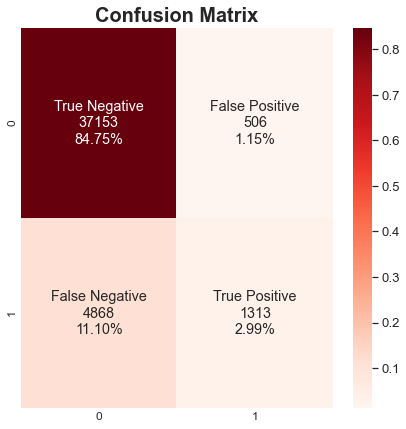

In [84]:
fig,ax = plt.subplots(figsize=(7,7))

conf_matrix = confusion_matrix(y_test, y_test_pred)
names = ['True Negative','False Positive','False Negative','True Positive']
counts = ['{}'.format(value) for value in conf_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix/np.sum(conf_matrix),fmt='',cmap='Reds',ax=ax,annot=labels)
ax.tick_params(axis='both', which='major', labelsize=12) 

plt.title('Confusion Matrix',fontsize=20,fontweight='bold')

plt.show()

In [85]:
precision = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])

In [86]:
print('Precision of the Decision Tree Classifier after Hyper-Parameter Tuning : {:.2f} %'.format(precision*100))
print('False Positive Rate of the Decision Tree Classifier after Hyper-Parameter Tuning : {:.2f} %'.format(fpr*100))

Precision of the Decision Tree Classifier after Hyper-Parameter Tuning : 72.18 %
False Positive Rate of the Decision Tree Classifier after Hyper-Parameter Tuning : 1.34 %


### Feature Importance

In [105]:
# Using the feature importance attribute of Random Forest
featImp = rfBest.feature_importances_
dfFeatImp = pd.DataFrame({'FeatureName':X_train.columns,'FeatureImportance':featImp})

In [106]:
# Features with feature importance of more than 0.01 
dfFeatImp = dfFeatImp[dfFeatImp['FeatureImportance']>0.01]

In [107]:
# Sorting the values in dataframe by Feature Importance
dfFeatImp.sort_values(by='FeatureImportance',inplace=True)

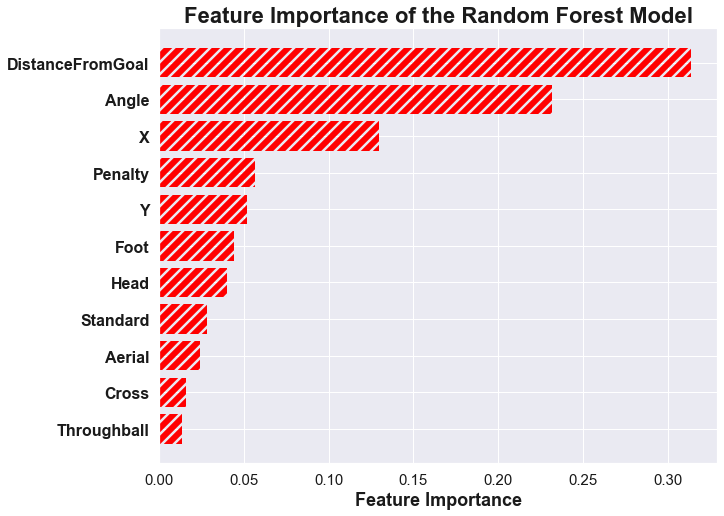

In [113]:
mpl.rcParams['hatch.linewidth']=6
fig,ax = plt.subplots(figsize=(10,8))

plt.barh(dfFeatImp['FeatureName'],dfFeatImp['FeatureImportance'],
         color='None',edgecolor='red',hatch='//',lw=0)
plt.xlabel('Feature Importance',fontsize=18,fontweight='bold',color='k')

plt.yticks(fontsize=16,color='k',fontweight='bold')
plt.xticks(fontsize=15,color='k')

plt.title('Feature Importance of the Random Forest Model',fontsize=22,fontweight='bold',color='k')
plt.show()

### AdaBoost Classifier

In [149]:
# Assigning parameters to perform Grid-Search on
parameters = {'base_estimator__max_depth':[5,6,7,8,9,10],
              'base_estimator__criterion': ['gini', 'entropy'],
              'n_estimators':np.linspace(100,500,5).astype(int),
              'learning_rate':[0.01,0.1,1,5]}

In [150]:
# Creating a Ada Boost Classifier Model to perform Grid Search with
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=23)

In [151]:
# Creating the GridSearch object 
clf = GridSearchCV(adaboost, parameters,scoring='roc_auc',n_jobs=-1)

In [138]:
# Fitting it on the training data
clf.fit(X_train,y_train)

GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=23),
             n_jobs=-1,
             param_grid={'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__max_depth': [5, 6, 7, 8, 9, 10],
                         'learning_rate': [0.01, 0.1, 1, 5],
                         'n_estimators': array([100, 200, 300, 400, 500])},
             scoring='roc_auc')

In [139]:
# Best parameters according to GridSearch
clf.best_params_

{'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 5,
 'learning_rate': 0.01,
 'n_estimators': 300}

In [ ]:
# Assigning the best parameter values
best_criteria = clf.best_params_['criterion']
best_depth = clf.best_params_['max_depth']
best_est = clf.best_params_['n_estimators']

In [140]:
# Creating a Random Forest Model with the best hyper-parameters found through GridSearch
adaboostBest = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='gini',max_depth=5),
                                  learning_rate=0.01, n_estimators=300, random_state=23)

In [141]:
adaboostBest.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.01, n_estimators=300, random_state=23)

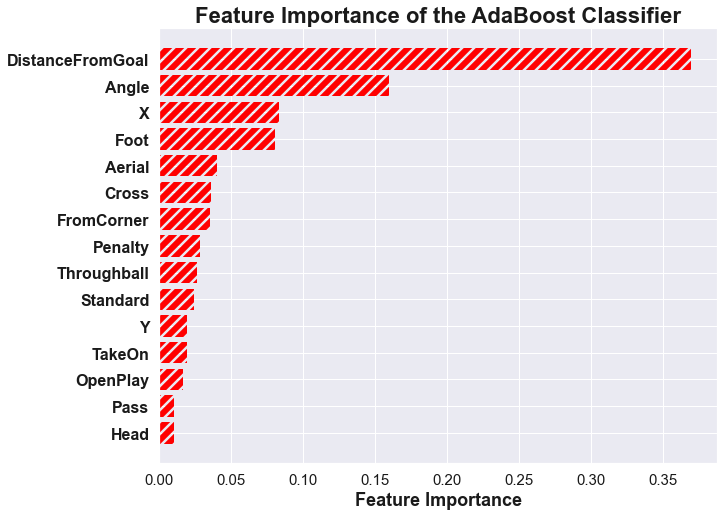

In [224]:
# Using the feature importance attribute of Random Forest
featImp = adaboostBest.feature_importances_
dfFeatImp = pd.DataFrame({'FeatureName':X_train.columns,'FeatureImportance':featImp})

# Features with feature importance of more than 0.01 
dfFeatImp = dfFeatImp[dfFeatImp['FeatureImportance']>0.01]

# Sorting the values in dataframe by Feature Importance
dfFeatImp.sort_values(by='FeatureImportance',inplace=True)

mpl.rcParams['hatch.linewidth']=6
fig,ax = plt.subplots(figsize=(10,8))

plt.barh(dfFeatImp['FeatureName'],dfFeatImp['FeatureImportance'],
         color='None',edgecolor='red',hatch='//',lw=0)
plt.xlabel('Feature Importance',fontsize=18,fontweight='bold',color='k')

plt.yticks(fontsize=16,color='k',fontweight='bold')
plt.xticks(fontsize=15,color='k')

plt.title('Feature Importance of the AdaBoost Classifier',fontsize=22,fontweight='bold',color='k')
plt.show()

In [143]:
y_train_pred = adaboostBest.predict(X_train) # Predicting on the training data
y_test_pred = adaboostBest.predict(X_test) # Predicting on the testing data
y_test_prob = adaboostBest.predict_proba(X_test)[:,1] # Predicting the probabilities on test data

In [144]:
accuracy_score(y_test,y_test_pred)

0.8773494525547445

In [145]:
print('ROC-AUC score of the Random Forest Classifier after Hyper-Parameter Tuning : {:.4f}'.format(roc_auc_score(y_test,y_test_prob)))

ROC-AUC score of the Random Forest Classifier after Hyper-Parameter Tuning : 0.8097


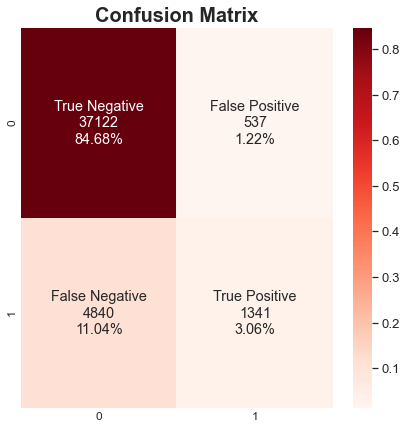

In [146]:
fig,ax = plt.subplots(figsize=(7,7))

conf_matrix = confusion_matrix(y_test, y_test_pred)
names = ['True Negative','False Positive','False Negative','True Positive']
counts = ['{}'.format(value) for value in conf_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix/np.sum(conf_matrix),fmt='',cmap='Reds',ax=ax,annot=labels)
ax.tick_params(axis='both', which='major', labelsize=12) 

plt.title('Confusion Matrix',fontsize=20,fontweight='bold')

plt.show()

In [147]:
precision = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
fnr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])

In [148]:
print('Precision of the Decision Tree Classifier after Hyper-Parameter Tuning : {:.2f} %'.format(precision*100))
print('False Positive Rate of the Decision Tree Classifier after Hyper-Parameter Tuning : {:.2f} %'.format(fpr*100))

Precision of the Decision Tree Classifier after Hyper-Parameter Tuning : 71.41 %
False Positive Rate of the Decision Tree Classifier after Hyper-Parameter Tuning : 1.43 %
